# SUJET : Simulation du taux de désabonnement des clients bancaires.

## 1. Introduction

  Pour prévenir le désabonnement des clients des banques, on identifie et visualise les facteurs qui conduisent au désabonnement et on construit des modèles prédictifs grâce à la machine learning pour déterminer si le client va se désabonner. Cela permet au service clientèle de la banque de mieux orienter ses efforts pour conserver les clients susceptibles de changer d'établissement.

Les jeux de données vient de https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers

 ## 2. Chargement des données et première analyse

### Importer les modules nécessaires

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pip
!pip install --upgrade pip
!pip install imblearn
!pip install seaborn
import seaborn as sns
from imblearn.over_sampling import SMOTE

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Chargement des données

In [2]:
df = pd.read_csv("BankChurners.csv",sep=',')
print(df.info(verbose=True))
print(df.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

 ### Détails des données associées
**'CLIENTNUM'**, ID du client.

**'Attrition_Flag'**, si le client est désabonné. 

**'Customer_Age'**, l'âge du client en années.

**'Gender'**, si le client est un homme ou une femme.

**'Dependent_count'**, le nombre de comptes dépendants.

**'Education_Level'**, les diplômes du titulaire du compte (par exemple : lycée, collège, etc.)

**'Marital_Status'**, l'état matrimonial (marié, célibataire, divorcé, inconnu)

**'Income_Category'**, le revenu annuel (USD). Catégorie de titulaire de compte (< 40k $, 40k $ à 60 000 $, 60k $ à 80 000 $, 80k $ à 120 000 $, >12k $). 

**'Card_Category'**, le type de carte (bleu, argent, or, platine).

**'Months_on_book'**, la durée de la relation avec la banque en mois.

**'Total_Relationship_Count'**, le nombre total de produits détenus par le client.

**'Months_Inactive_12_mon'**, le nombre de mois inactifs au cours des 12 derniers mois.

**'Contacts_Count_12_mon'**, le nombre de contacts au cours des 12 derniers mois.

**'Credit_Limit'**, la limite de crédit de la carte de crédit.

**'Total_Revolving_Bal'**, le solde renouvelable total de la carte de crédit.

**'Avg_Open_To_Buy'**, le crédit d'achat ouvert (moyenne des 12 derniers mois).

**'Total_Amt_Chng_Q4_Q1'**, la variation des montants des transactions (Q4 par rapport à Q1, Q4 pour le quatrième trimestre, Q1 pour le premier trimestre).

**'Total_Trans_Amt'**, le montant total de la transaction (12 derniers mois).

**'Total_Trans_Ct'**, la variation du nombre de transactions (Q4 par rapport à Q1).

**'Total_Ct_Chng_Q4_Q1'**, le nombre total de transactions (12 derniers mois).

**'Avg_Utilization_Ratio'**, le taux d'utilisation moyen des cartes.

**'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'**, les résultats des méthodes bayésiennes.

**'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'**, Les résultats des méthodes bayésiennes.

### Élimination des données dupliquées et manquantes

Pour une meilleure utilisation des données, on supprime les lignes complètes dupliquées. Aussi, on peut supprimer les deux dernières colonnes des données représentant les résultats de la classification bayésienne, ainsi que la variable sans importance : numéro de client--'CLIENTNUM'. 

In [3]:
df = df[df.columns[:-2]]
df=df.drop_duplicates()#Supprimer les lignes dupliquées
df=df.drop(['CLIENTNUM'], axis = 1)
print (df.isnull().sum().sort_values(ascending=False))#df=df.dropna() Filtrer les données manquante

Avg_Utilization_Ratio       0
Total_Ct_Chng_Q4_Q1         0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Attrition_Flag              0
dtype: int64


### Analyse exploratoire des données(EDA)

Tout d'abord, on trace un diagramme sectoriel sur la caractéristique de l'étiquette.

count                 10127
unique                    2
top       Existing Customer
freq                   8500
Name: Attrition_Flag, dtype: object


Text(0.5, 1.0, "Répartition de l'état de l'abonnement du client")

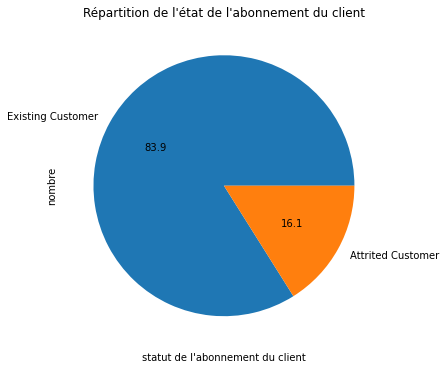

In [4]:
print(df['Attrition_Flag'].describe())
value=df['Attrition_Flag'].value_counts(normalize=True)
value.plot(figsize=(8,6),kind='pie',autopct="%0.1f")
plt.xlabel("statut de l'abonnement du client")
plt.ylabel("nombre")
plt.title("Répartition de l'état de l'abonnement du client")

Dans le graphique sectoriel, vous pouvez voir que le "Client Désabonné" est un client qui a changé d'établissement et que le "Client Abonné" est un client qui n'a pas changé d'établissement. Le pourcentage de clients désabonné est de 16,1 % et le pourcentage de clients abonné est de 83,9 %. Ces 16 % ne représentent pas un pourcentage élevé de clients et, dans les prochaines étapes, j'utiliserai SMOTE pour échantillonner l'échantillon de clients désabonné de manière à ce qu'il corresponde à la taille de l'échantillon de clients abonné afin de donner au modèle choisi ultérieurement une meilleure chance de capturer les petits détails.

On trace ensuite des diagrammes sectoriels pour les caractéristiques du type d'objet.

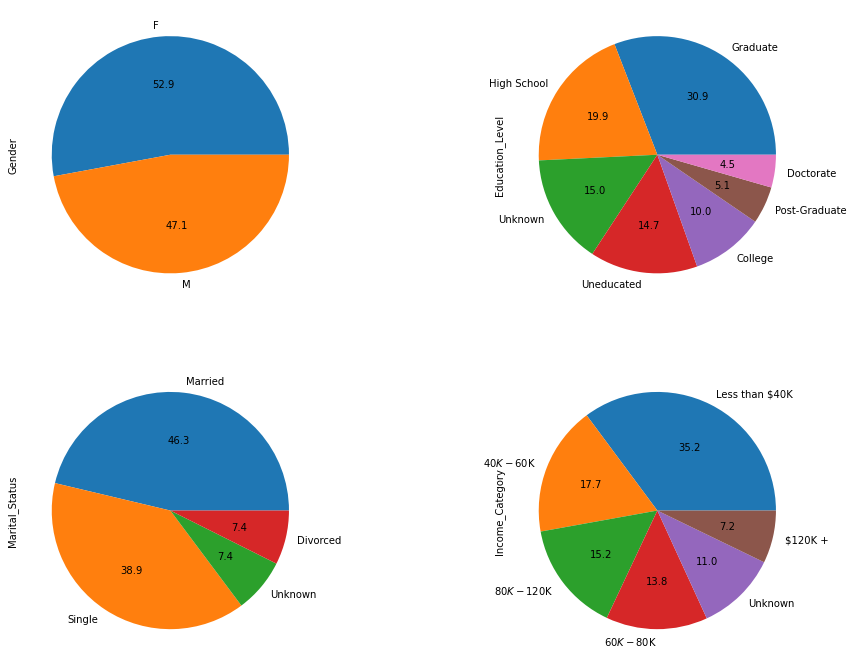

In [5]:
pielist=['Gender','Education_Level','Marital_Status','Income_Category']
fig, axarr = plt.subplots(2, 2, figsize=(16, 12))
for i in range(len(pielist)):
    valu=df[pielist[i]].value_counts(normalize=True)
    valu.plot(figsize=(16,12),kind='pie',autopct="%0.1f",ax=axarr[i//2][i%2])

D'après ces graphiques, on constate que la répartition des clients par sexe est relativement équilibrée. Toutefois, un faible pourcentage de "Unknown" est présent dans certaines caractéristiques. Dans la section suivante, on traitera de ce problème.

 ## 3. Préparation du jeu de données

On remplace "Unknown" par la catégorie la plus nombreuse dans chaque caractéristique.

In [6]:
df['Education_Level'] = df['Education_Level'].replace('Unknown', 'Graduate')
df['Marital_Status'] = df['Marital_Status'].replace('Unknown', 'Married')
df['Income_Category'] = df['Income_Category'].replace('Unknown', 'Less than $40K')

On veut maintenant coder les caractères des caractéristiques du type d'objet pour faciliter l'apprentissage du modèle par la suite. En effet, l‘ordinateur ne lit pas les caractères.

Tout d'abord, on remplace la caractéristique de l'étiquette par des nombres, en utilisant 1 pour "client abonné" et 0 pour "client désabonné"

In [7]:
from sklearn.preprocessing import LabelEncoder
lab=LabelEncoder()
df['Attrition_Flag']=lab.fit_transform(df['Attrition_Flag'])

Les catégories restantes qui ont plusieurs valeurs de caractéristiques textuelles sont ensuite codées.

In [8]:
objcol=df.select_dtypes(['object']).columns
for i in range(len(objcol)):
    df=df.join(pd.get_dummies(df[objcol[i]]))
    df=df.drop([objcol[i]], axis = 1)
print(df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10127 entries, 0 to 10126
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int64  
 1   Customer_Age              10127 non-null  int64  
 2   Dependent_count           10127 non-null  int64  
 3   Months_on_book            10127 non-null  int64  
 4   Total_Relationship_Count  10127 non-null  int64  
 5   Months_Inactive_12_mon    10127 non-null  int64  
 6   Contacts_Count_12_mon     10127 non-null  int64  
 7   Credit_Limit              10127 non-null  float64
 8   Total_Revolving_Bal       10127 non-null  int64  
 9   Avg_Open_To_Buy           10127 non-null  float64
 10  Total_Amt_Chng_Q4_Q1      10127 non-null  float64
 11  Total_Trans_Amt           10127 non-null  int64  
 12  Total_Trans_Ct            10127 non-null  int64  
 13  Total_Ct_Chng_Q4_Q1       10127 non-null  float64
 14  Avg_Ut

On trace la carte thermique pour toutes les caractéristiques. 

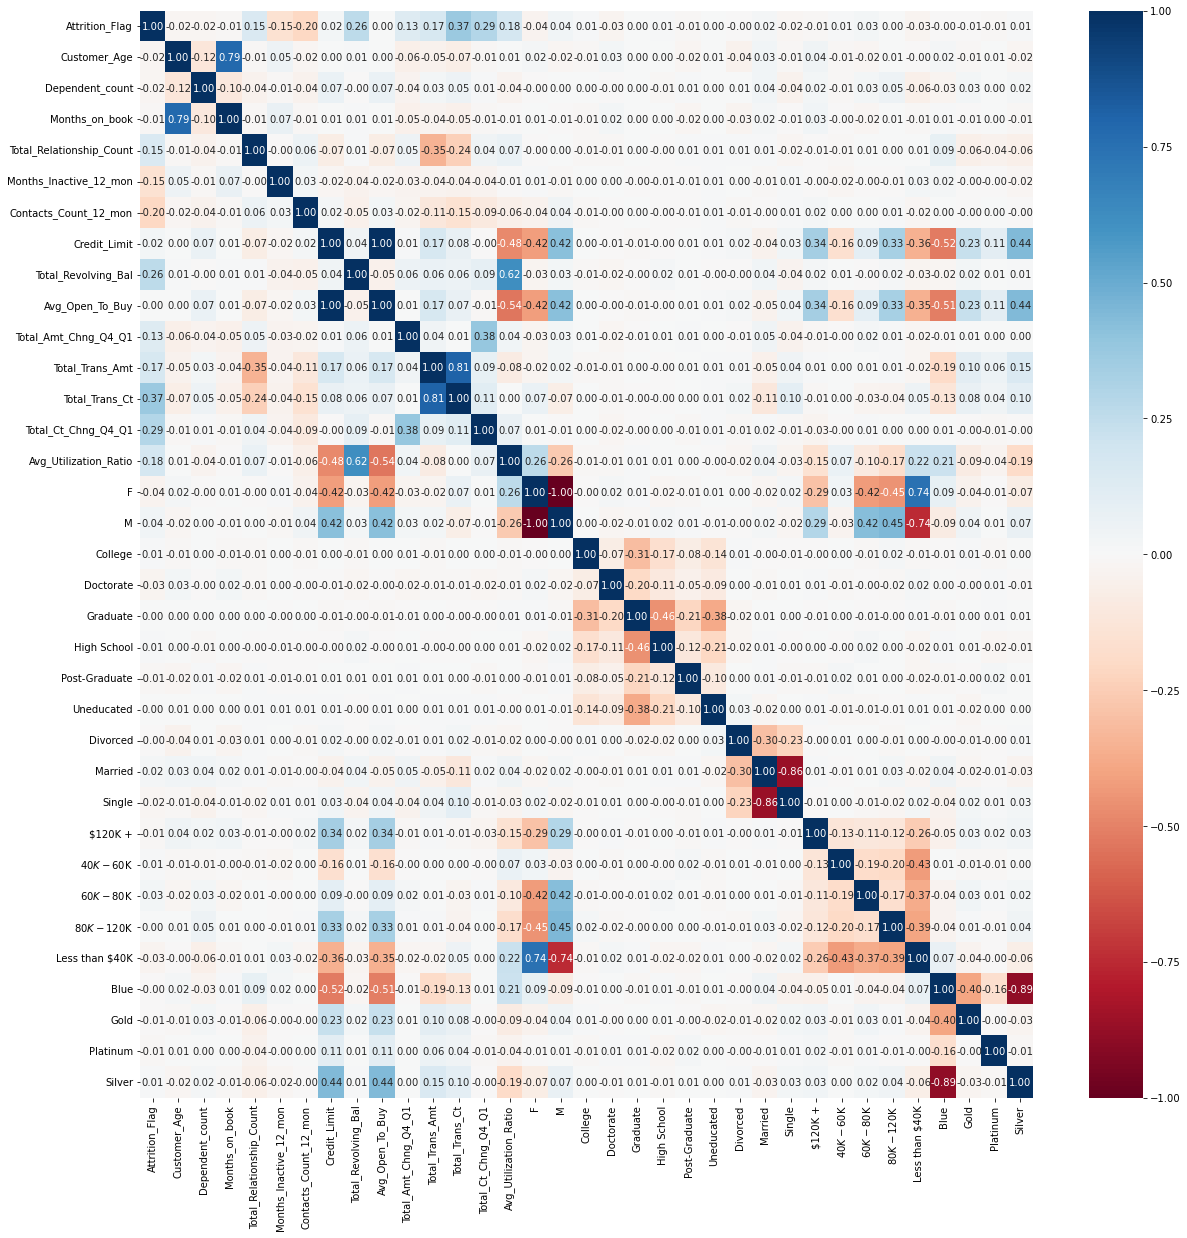

In [9]:
plt.figure(figsize=(20,20))
corr = df.corr()
sns.heatmap(corr,cmap='RdBu',annot=True,fmt='.2f')
plt.show()

On a trouvé un certain nombre de caractéristiques qui sont particulièrement pertinentes pour la caractéristique d'étiquetage. Par exemple,'Total_Trans_Ct' et 'Total_Ct_Chng_Q4_Q1'. Elles sont positivement corrélées avec la caractéristique d‘étiquetage, ce qui signifie que plus la valeur de ces deux caractéristiques est élevée, moins le client est susceptible de se désabonner. Les rubriques "Months_Inactive_12_mon" et "Contacts_Count_12_mon" sont négativement corrélées avec la caractéristique de l'étiquetage. Plus ces deux éléments sont élevés, plus le client est susceptible de se désabonner.

Le jeu de données est très déséquilibré.Nous devrons faire un suréchantillonnage(upsampling) ou un sous-échantillonnage(downsampling). Nous utilisons l'algorithme SMOTE pour synthétiser les échantillons de la classe minoritaire dans le problème de classification afin d'équilibrer les échantillons.

Le principe de la stratégie de synthèse est le suivant : pour chaque échantillon de classe minoritaire A, un échantillon B est sélectionné au hasard parmi ses voisins les plus proches, puis un point situé sur la ligne entre A et B est sélectionné au hasard comme échantillon de classe minoritaire nouvellement synthétisé (remplissage approximatif).

In [10]:
smodel = SMOTE(k_neighbors=2, random_state=42)
x_smote, y_smote = smodel.fit_resample(df[df.columns[1:]],df[df.columns[0]])
dfsmo = pd.concat([y_smote, x_smote], axis=1)

Nous traçons un graphique pour vérifier que les deux valeurs caractéristiques de "Attrition_Flag" sont dans un rapport 1:1.

count    17000.000000
mean         0.500000
std          0.500015
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: Attrition_Flag, dtype: float64


Text(0.5, 1.0, "Répartition de l'état de l'abonnement du client")

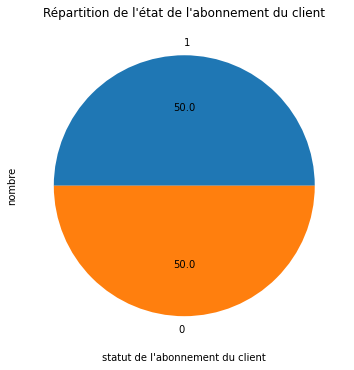

In [11]:
print(dfsmo['Attrition_Flag'].describe())
value=dfsmo['Attrition_Flag'].value_counts(normalize=True)
value.plot(figsize=(8,6),kind='pie',autopct="%0.1f")
plt.xlabel("statut de l'abonnement du client")
plt.ylabel("nombre")
plt.title("Répartition de l'état de l'abonnement du client")

Maintenant que les données sont équilibrées, on peut commencer l'entraînement.

## 4. PCA

On a 14 caractéristiques de variables continues, ce qui est trop et peut affecter le temps nécessaire à l'apprentissage du modèle. On peut utiliser la méthode de PCA pour réduire la dimensionnalité de ces données.

In [12]:
from sklearn.decomposition import PCA

Afin d'éviter que certaines caractéristiques à forte variance ne dominent les résultats de l'analyse en composantes principales, les données utilisées seront normalisées.

In [13]:
continuous_vars=['Customer_Age','Dependent_count','Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon','Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal','Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt','Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']
minVec = dfsmo[continuous_vars].min().copy()
maxVec = dfsmo[continuous_vars].max().copy()
dfsmo[continuous_vars] = (dfsmo[continuous_vars]-minVec)/(maxVec-minVec)
dfsmo.head()

,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Single,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Blue,Gold,Platinum,Silver
0,1,0.404255,0.6,0.604651,0.8,0.166667,0.500000,0.340190,0.308701,0.345116,...,0,0,0,1,0,0,1,0,0,0
1,1,0.489362,1.0,0.720930,1.0,0.166667,0.333333,0.206112,0.343266,0.214093,...,1,0,0,0,0,1,1,0,0,0
2,1,0.531915,0.6,0.534884,0.6,0.166667,0.000000,0.059850,0.000000,0.098948,...,0,0,0,0,1,0,1,0,0,0
3,1,0.297872,0.8,0.488372,0.4,0.666667,0.166667,0.056676,1.000000,0.022977,...,0,0,0,0,0,1,1,0,0,0
4,1,0.297872,0.6,0.186047,0.8,0.166667,0.000000,0.099091,0.000000,0.136557,...,0,0,0,1,0,0,1,0,0,0


Pour déterminer le nombre de composantes nécessaires, on a traité les données séparément pour 1 à 10 composantes et on a calculé la variance totale correspondante.

<function matplotlib.pyplot.show(close=None, block=None)>

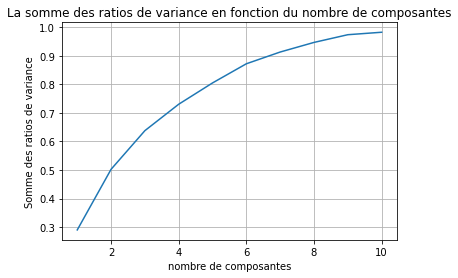

In [14]:
continuous_vars=['Customer_Age','Dependent_count','Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon','Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal','Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt','Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']
dfpca0=dfsmo[continuous_vars]

varisom=np.ones(10)

for N in range(10):
    pca = PCA(n_components=N+1)
    dfpca = pca.fit_transform(dfpca0)
    ex_vari = pca.explained_variance_ratio_
    varisom[N]=np.sum(ex_vari)

plt.plot(range(1,11),varisom)
plt.xlabel('nombre de composantes')
plt.ylabel('Somme des ratios de variance')
plt.title("La somme des ratios de variance en fonction du nombre de composantes")
plt.grid()
plt.savefig('nbr_com.png')
plt.show

Selon le graphique, on a décidé 7 composantes parce que la somme des variances à ce stade atteignait environ 90%. Parce que cette variance signifie qu'une partie suffisante de l'information d'origine a été conservée. On combine les nouvelles données obtenues avec d'autres variables non continues et on trace la nouvelle carte thermique.

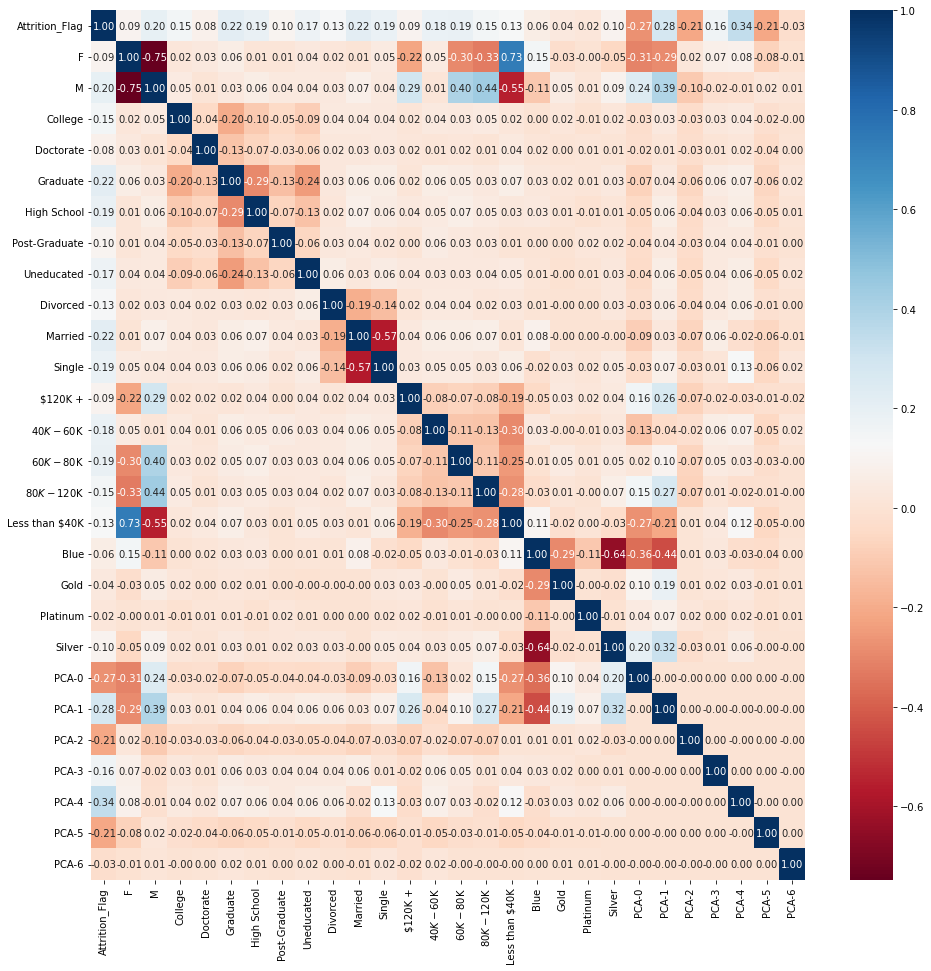

In [18]:
pca = PCA(n_components=7)
dfpca = pca.fit_transform(dfpca0)
dfpca=pd.DataFrame(dfpca,columns=['PCA-{}'.format(i) for i in range(7)])
dff=dfsmo.drop(continuous_vars, axis = 1)
dff=pd.concat([dff,dfpca], axis=1)
plt.figure(figsize=(16,16))
corr = dff.corr()
sns.heatmap(corr,cmap='RdBu',annot=True,fmt='.2f')
plt.show()

Par rapport à la carte thermique précédente, le nouveau graphique est plus concis et les caractéristiques sont plus évidentes.

## 5. Arbre de décision

Sélection d'un modèle d'arbre de décision

In [19]:
feat=dff.drop(['Attrition_Flag'], axis = 1)
label=dff['Attrition_Flag']

In [20]:
from sklearn.model_selection import train_test_split
feat_train, feat_test, label_train, label_test = train_test_split(feat, label, test_size=0.3)

In [21]:
from sklearn import tree
clf1 = tree.DecisionTreeClassifier(max_depth=None)
clf1.fit(feat_train, label_train)

DecisionTreeClassifier()

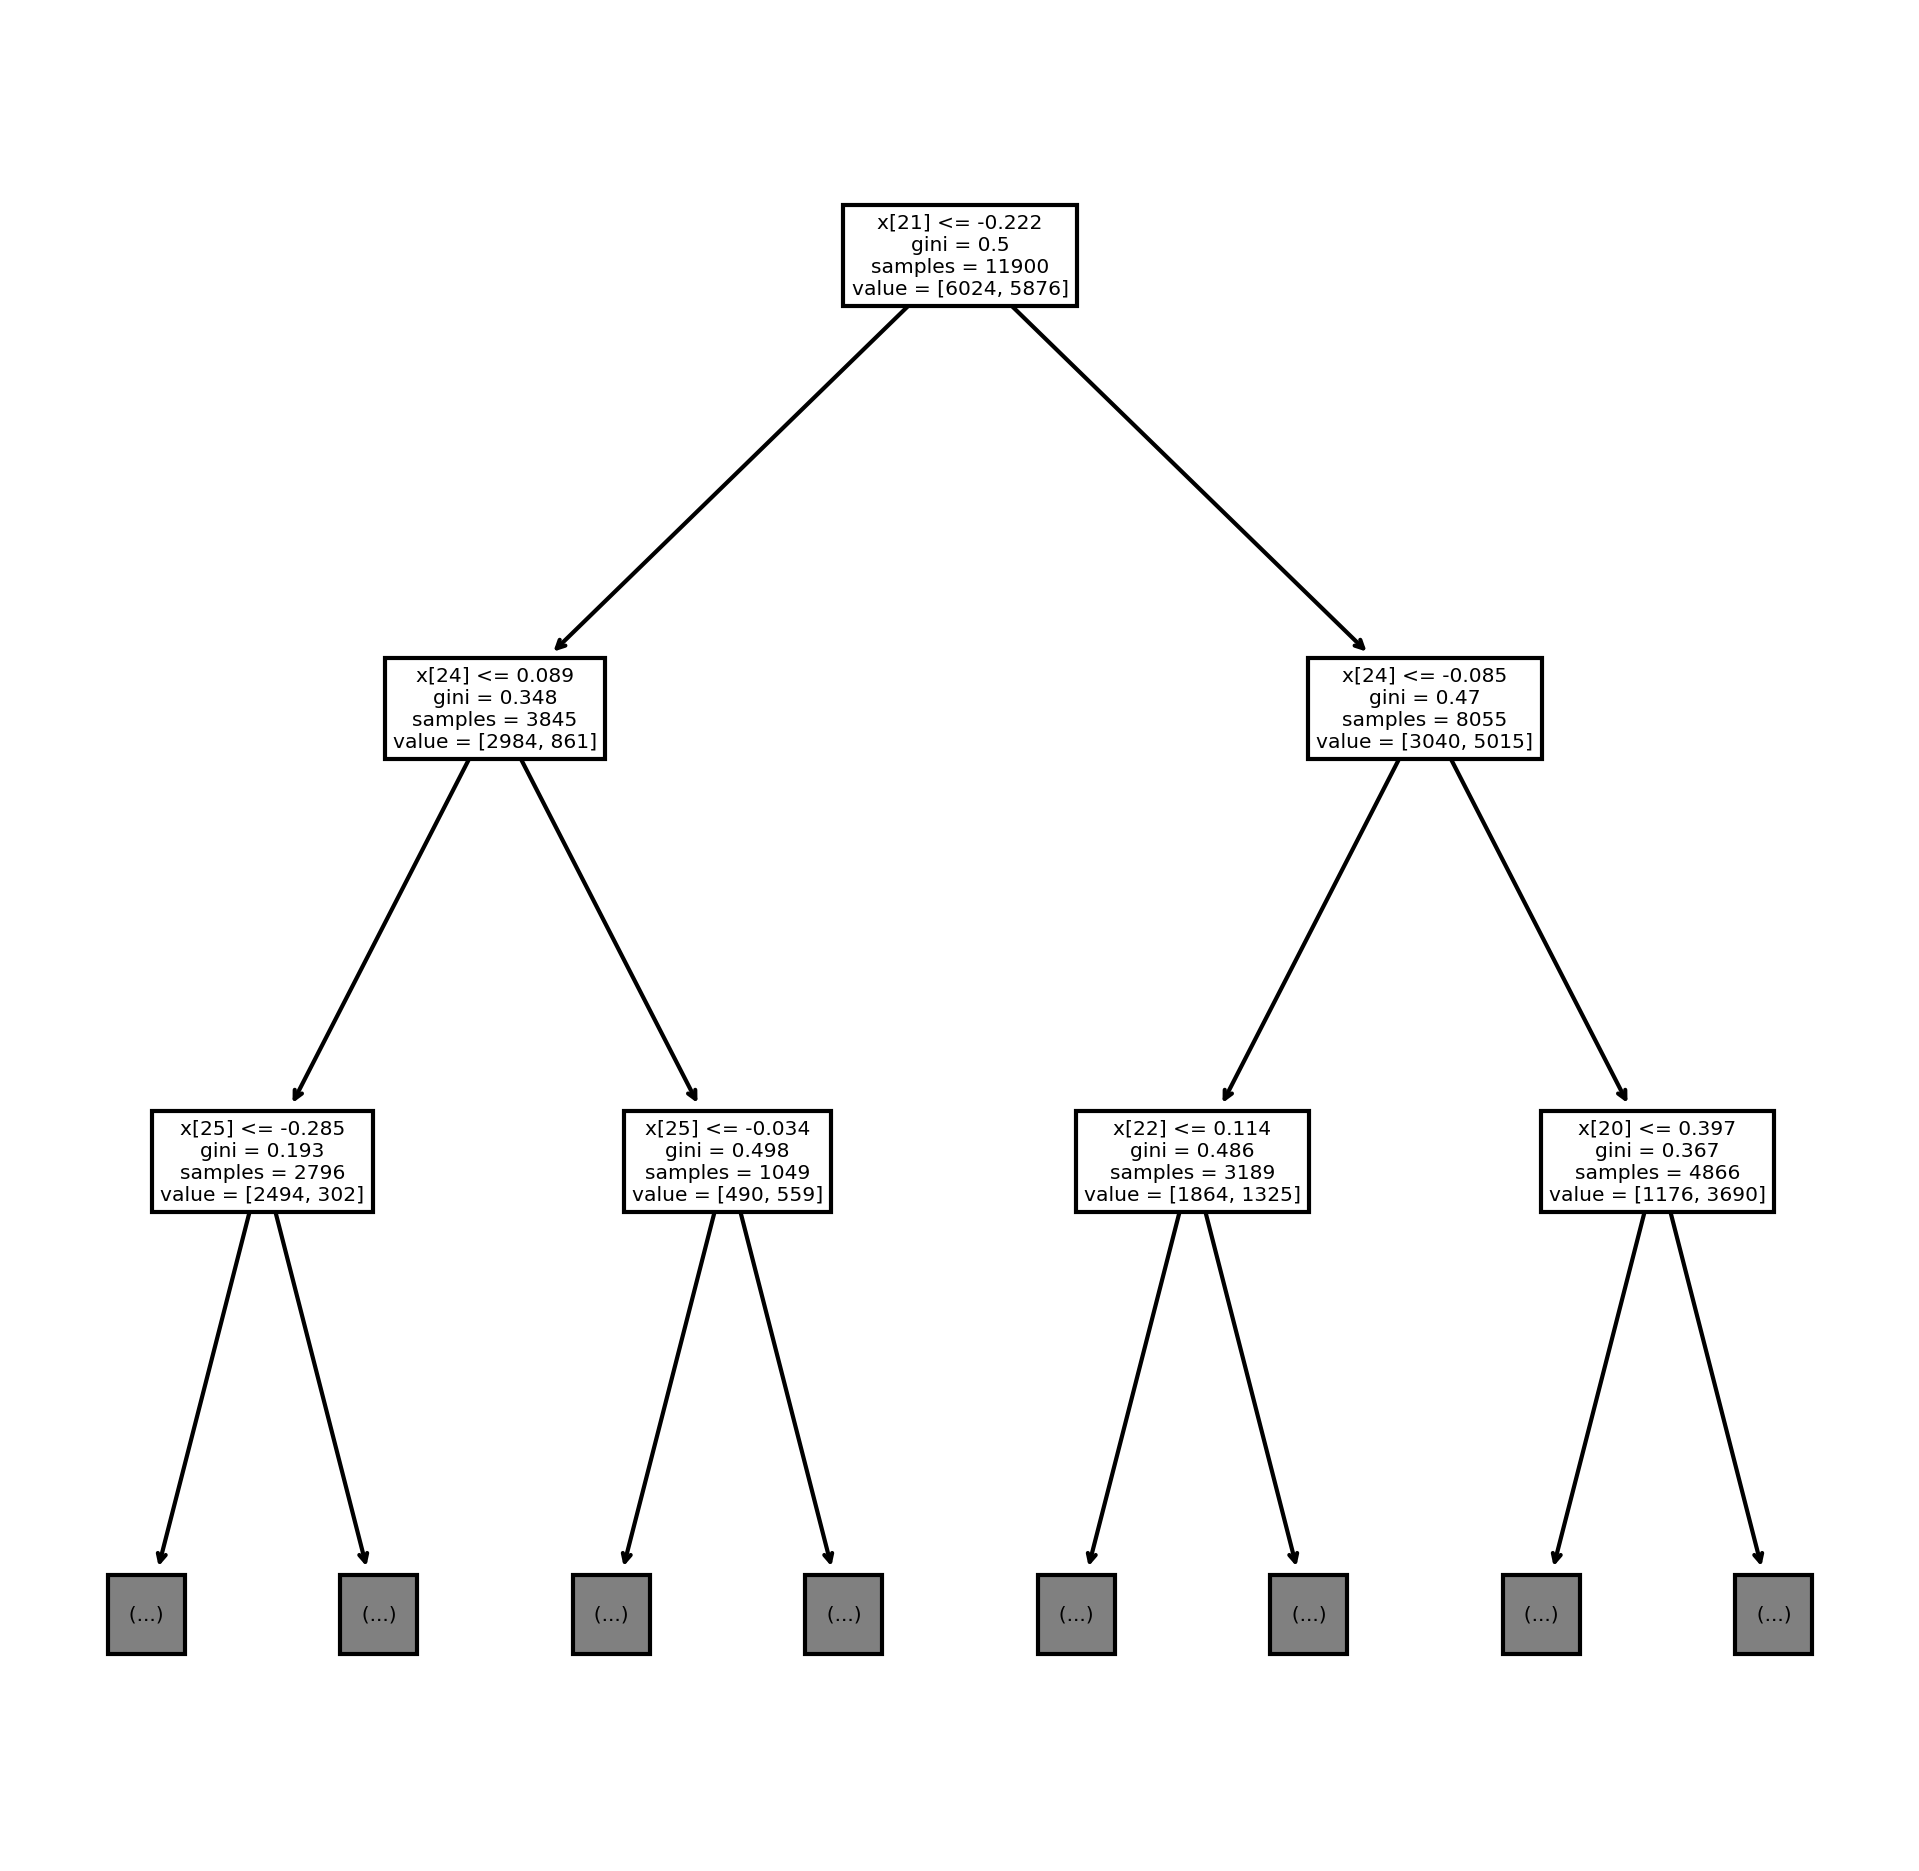

In [22]:
plt.figure(figsize=(8, 8), dpi=300)
tree.plot_tree(clf1.fit(feat_train, label_train), max_depth=2)
# plt.savefig("tree.png")
plt.show()

On fait des prédictions pour les 10 dernières lignes de l'ensemble de test et on les compare aux vraies étiquettes.

In [27]:
pred_label1= clf1.predict(feat_test)
print("prédiction", pred_label1[-10:])
print("observation",label_test[-10:])

prédiction [1 1 1 1 0 1 0 1 0 0]
observation 6977     1
7438     1
1664     1
9447     1
12264    0
4848     1
15776    0
4010     1
8253     1
16247    0
Name: Attrition_Flag, dtype: int64


On constate que 1/10 des prédictions du modèle d'arbre de décision sont erronées. On peut calculer la précision du modèle.

In [28]:
accuracy1=clf1.score(feat_test, label_test)
print(accuracy1)

0.8772549019607843


La précision du modèle est 87.7%

## 6. Random Forest

Sélection d'un modèle Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(n_estimators=100)
clf2.fit(feat_train, label_train)

RandomForestClassifier()

On fait des prédictions pour les 10 dernières lignes de l'ensemble de test et on les compare aux vraies étiquettes

In [30]:
pred_label2=clf2.predict(feat_test)
print("prédiction", pred_label2[-10:])
print("observation",label_test[-10:])

prédiction [1 1 1 1 0 1 0 1 1 0]
observation 6977     1
7438     1
1664     1
9447     1
12264    0
4848     1
15776    0
4010     1
8253     1
16247    0
Name: Attrition_Flag, dtype: int64


On constate que tous les prédictions du modèle Random Forest sont correctes. On peut calculer la précision du modèle.

In [31]:
accuracy2=clf2.score(feat_test, label_test)
print(accuracy2)

0.937843137254902


La précision du modèle Random Forest est 93.7%. Ce modèle est plus précis que le modèle de l'arbre de décision.

## 7. Performances du classificateur : courbe ROC

Tracer les courbes roc pour sélectionner le modèle optimal. Lors de l'évaluation des meilleurs modèles, on s'intéresse principalement à la prédiction d'une valeur de "0", car une valeur de "0" indique un client désabonné.

In [33]:
ad=clf1.predict_proba(feat_test)
rf=clf2.predict_proba(feat_test)

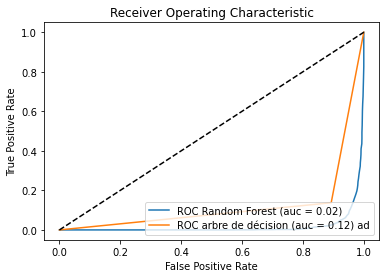

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score
add=ad[:,0]
rff=rf[:,0]
fprrf, tprrf, thresholdsrf = roc_curve(label_test, rff)
fprad, tprad, thresholdsad = roc_curve(label_test, add)
aucrf = roc_auc_score(label_test, rff)
aucad = roc_auc_score(label_test, add)
plt.plot(fprrf, tprrf, label='ROC Random Forest (auc = %0.2f)' % aucrf)
plt.plot(fprad, tprad, label='ROC arbre de décision (auc = %0.2f) ad' % aucad)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Dans ce cas, plus l'aire sous la courbe (AUC) est proche de 0, meilleure est la performance prédictive du modèle pour les clients désabonnés. Donc, on dit que le modèle Random Forest est le modèle optimal. Lorsque on utilise ce modèle pour prédire qu'un client va se désabonner, il faut considérer la possibilité d'offrir plus de services à ce client, ou au moins de lui consacrer plus d'attention.

## 8.Les pistes d'amélioration ou d'approfondissement.
Il est également possible d'améliorer les paramètres optimaux du modèle. Et si on possédait plus de données sur les clients, comme leur état de santé ou leur satisfaction à l'égard des services, on pourrait analyser ce qui les pousse à se désabonner et offrir des services plus précis pour les conserver.